In [2]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import time

# Parametry
JSON_PATH = "../data/clean_data_train_01.json"
IMAGE_DIR = "../data/images/"
MODEL_SAVE_DIR = "../models/"
IMG_HEIGHT, IMG_WIDTH = 140, 100
NUM_IMAGES = 12
BATCH_SIZE = 16
NUM_EPOCHS = 55
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
class CarDataset(Dataset):
    def __init__(self, json_path, image_dir, transform=None, num_images=NUM_IMAGES, debug=False):
        self.image_dir = image_dir
        self.transform = transform
        self.num_images = num_images
        self.debug = debug

        # Wczytaj dane JSON
        self.data = pd.read_json(json_path, lines=True)

        # Filtruj dane, aby uwzględnić tylko oferty z przynajmniej jednym zdjęciem
        self.samples = []
        for _, row in self.data.iterrows():
            car_id = str(row["id"])
            has_images = any(
                Path(self.image_dir, f"{car_id}_{i}.jpg").exists() for i in range(1, self.num_images + 1)
            )
            if has_images:
                self.samples.append({
                    "id": car_id,
                    "price": row["cena"],  # Cena samochodu
                })

        print(f"Debug: Dataset contains {len(self.samples)} samples.")

        # Wczytaj wszystkie dane jednorazowo do pamięci RAM
        self.loaded_data = []
        for idx, sample in enumerate(self.samples):
            car_id = sample["id"]
            price = sample["price"]

            # Załaduj zdjęcia
            images = []
            for i in range(1, self.num_images + 1):
                image_path = Path(self.image_dir, f"{car_id}_{i}.jpg")
                if image_path.exists():
                    img = Image.open(image_path).convert("RGB")
                    if self.transform:
                        img = self.transform(img)
                    images.append(img)

            # Jeśli brakuje zdjęć, powielaj istniejące
            while len(images) < self.num_images:
                images.append(images[-1])

            # Przytnij, jeśli jest za dużo zdjęć
            images = images[:self.num_images]
            images = torch.stack(images)  # [NUM_IMAGES, C, H, W]

            # Zapisz przetworzone dane w pamięci
            self.loaded_data.append((images, torch.tensor(price, dtype=torch.float32)))

            # Loguj co 100 próbek
            if (idx + 1) % 100 == 0:
                print(f"Loaded {idx + 1}/{len(self.samples)} samples into memory.")

    def __len__(self):
        return len(self.loaded_data)

    def __getitem__(self, idx):
        # Pobierz dane bezpośrednio z pamięci
        return self.loaded_data[idx]


# Model
class CarPriceRegressor(nn.Module):
    def __init__(self, num_images=NUM_IMAGES):
        super(CarPriceRegressor, self).__init__()
        # Model bazowy (ResNet18)
        self.base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.base_model.fc = nn.Identity()  # Usuń klasyfikator na końcu

        # Przetwarzanie obrazów
        self.embedding_size = 512  # Rozmiar embeddingu z ResNet18
        self.fc = nn.Linear(self.embedding_size, 1)  # Regresja zamiast klasyfikacji

    def forward(self, x):
        # x: [BATCH_SIZE, NUM_IMAGES, C, H, W]
        batch_size, num_images, C, H, W = x.size()
        
        # Przetwarzanie każdego obrazu w ramach jednej oferty
        embeddings = []
        for i in range(num_images):
            img_features = self.base_model(x[:, i, :, :, :])  # Przetwarzanie pojedynczego obrazu
            embeddings.append(img_features)
        
        # Łączenie cech obrazów przy użyciu max pooling
        embeddings = torch.stack(embeddings, dim=1)  # [BATCH_SIZE, NUM_IMAGES, EMBEDDING_SIZE]
        combined_embedding, _ = embeddings.max(dim=1)  # [BATCH_SIZE, EMBEDDING_SIZE]
        
        # Regresja na podstawie połączonych cech
        output = self.fc(combined_embedding)  # [BATCH_SIZE, 1]
        return output.squeeze()  # [BATCH_SIZE]

# Transformacje dla obrazów
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



class MAPE(nn.Module):
    def __init__(self):
        super(MAPE, self).__init__()

    def forward(self, predictions, targets):
        epsilon = 1e-6  # Aby uniknąć dzielenia przez zero
        mape = torch.mean(torch.abs((targets - predictions) / (targets + epsilon))) * 100
        return mape


# Model, funkcja kosztu, optymalizator
model = CarPriceRegressor(num_images=NUM_IMAGES).to(DEVICE)
criterion = MAPE()  # Funkcja kosztu dla regresji
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [ ]:
# Trenowanie
# Dataset i DataLoader
#MAX_SAMPLES = 5000
train_dataset = CarDataset(JSON_PATH, IMAGE_DIR, transform=transform) 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

import time
import torch
from torch.utils.data import DataLoader

for epoch in range(NUM_EPOCHS):
    # Rozpocznij pomiar czasu dla całej epoki
    epoch_start_time = time.time()

    model.train()
    epoch_loss = 0
    total_mape = 0

    # Inicjalizacja liczników czasu
    data_loading_time = 0
    computation_time = 0
    data_transfer_time = 0
    x_time = time.time()
    
    for i, (images, prices) in enumerate(train_loader, start=1):
        # Pomiar czasu na początku iteracji
        iter_start_time = time.time()

        # Rozpocznij pomiar czasu ładowania danych
        start_time = time.time()
        # Przenieś dane na urządzenie
        images, prices = images.to(DEVICE), prices.to(DEVICE)
        load_time = time.time() - start_time
        data_loading_time += load_time

        # Rozpocznij pomiar czasu transferu danych
        start_time = time.time()
        transfer_time = time.time() - start_time
        data_transfer_time += transfer_time

        # Rozpocznij pomiar czasu obliczeń
        start_time = time.time()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, prices)
        loss.backward()
        optimizer.step()
        comp_time = time.time() - start_time
        computation_time += comp_time

        # Akumulacja metryk
        epoch_loss += loss.item()
        total_mape += torch.mean(torch.abs((prices - outputs) / prices)).item() * 100

        # Koniec pomiaru czasu iteracji
        iter_total_time = time.time() - iter_start_time
        x_total_time = time.time() - x_time
        x_time = time.time()

        # Logowanie co 10 iteracji
        # if i % 100 == 0:
        #     print(
        #         f"Epoch [{epoch+1}/{NUM_EPOCHS}], Iteration [{i}/{len(train_loader)}]: "
        #         f"Total Time: {iter_total_time:.4f}s, "
        #         f"Data Loading Time: {load_time:.4f}s, "
        #         f"Computation Time: {comp_time:.4f}s, "
        #         f"Data Transfer Time: {transfer_time:.4f}s"
        #         f"X Time: {x_total_time:.4f}s, "
        #     )

    # Oblicz czas trwania epoki
    epoch_time = time.time() - epoch_start_time

    # Średnia strata i MAPE
    avg_loss = epoch_loss / len(train_loader)
    avg_mape = total_mape / len(train_loader)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Summary:")
    print(f"  Train Loss: {avg_loss:.4f}, Train MAPE: {avg_mape:.2f}%")
    print(f"  Total Data Loading Time: {data_loading_time:.2f}s, Total Computation Time: {computation_time:.2f}s, Total Data Transfer Time: {data_transfer_time:.2f}s")
    print(f"  Total Epoch Time: {epoch_time:.2f}s")


# Tworzenie katalogu na zapis modelu
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Zapis modelu
model_path = os.path.join(MODEL_SAVE_DIR, "car_price_regressor.pth")
torch.save(model.state_dict(), model_path)
print(f"Model zapisany w: {model_path}")

In [3]:
def load_model(model, model_path, device="cuda"):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()  # Przełącz model w tryb ewaluacji
    print(f"Model loaded from {model_path}.")
    return model


In [4]:
def evaluate(model, test_loader, criterion, device="cuda", log_interval=100):
    print("Starting evaluation...")
    model.eval()
    total_loss = 0
    total_mape = 0
    total_samples = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch_idx, (images, prices) in enumerate(test_loader):
            images, prices = images.to(device), prices.to(device)
            predictions = model(images)

            # Akumulacja strat
            loss = criterion(predictions, prices)
            total_loss += loss.item() * images.size(0)
            total_mape += torch.sum(torch.abs((prices - predictions) / (prices + 1e-6))).item() * 100
            total_samples += images.size(0)

            # Zbieranie przewidywań i wartości rzeczywistych
            y_pred.extend(predictions.cpu().tolist())
            y_true.extend(prices.cpu().tolist())

            # Logowanie częściowych wyników
            if (batch_idx + 1) % log_interval == 0:
                print(f"Batch {batch_idx + 1}/{len(test_loader)}:")
                print(f"  Partial Loss: {loss.item():.4f}, Partial MAPE: {torch.mean(torch.abs((prices - predictions) / (prices + 1e-6))).item() * 100:.2f}%")
    
    # Obliczanie średnich metryk
    avg_loss = total_loss / total_samples
    avg_mape = total_mape / total_samples

    print(f"Evaluation Summary: MAPE: {avg_mape:.2f}%, Average Loss: {avg_loss:.4f}")
    return avg_loss, avg_mape, y_pred, y_true


In [8]:
TEST_JSON_PATH = "../data/clean_data_test_01.json"
test_dataset = CarDataset(TEST_JSON_PATH, IMAGE_DIR, transform=transform) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

MODEL_PATH = os.path.join(MODEL_SAVE_DIR, "car_price_regressor.pth")
# Stwórz instancję modelu i wczytaj wagi
model = CarPriceRegressor(num_images=NUM_IMAGES)
model = load_model(model, MODEL_PATH, device=DEVICE)

avg_loss, avg_mape, y_pred, y_true = evaluate(
    model=model,
    test_loader=test_loader,
    criterion=MAPE(),
    device=DEVICE
)

Debug: Dataset contains 1464 samples.
Loaded 100/1464 samples into memory.
Loaded 200/1464 samples into memory.
Loaded 300/1464 samples into memory.
Loaded 400/1464 samples into memory.
Loaded 500/1464 samples into memory.
Loaded 600/1464 samples into memory.
Loaded 700/1464 samples into memory.
Loaded 800/1464 samples into memory.
Loaded 900/1464 samples into memory.
Loaded 1000/1464 samples into memory.
Loaded 1100/1464 samples into memory.
Loaded 1200/1464 samples into memory.
Loaded 1300/1464 samples into memory.
Loaded 1400/1464 samples into memory.


C:\Users\tthaddey\AppData\Local\Temp\ipykernel_22792\935200661.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Model loaded from ../models/car_price_regressor.pth.
Starting evaluation...
Evaluation Summary: MAPE: 83.29%, Average Loss: 83.2923


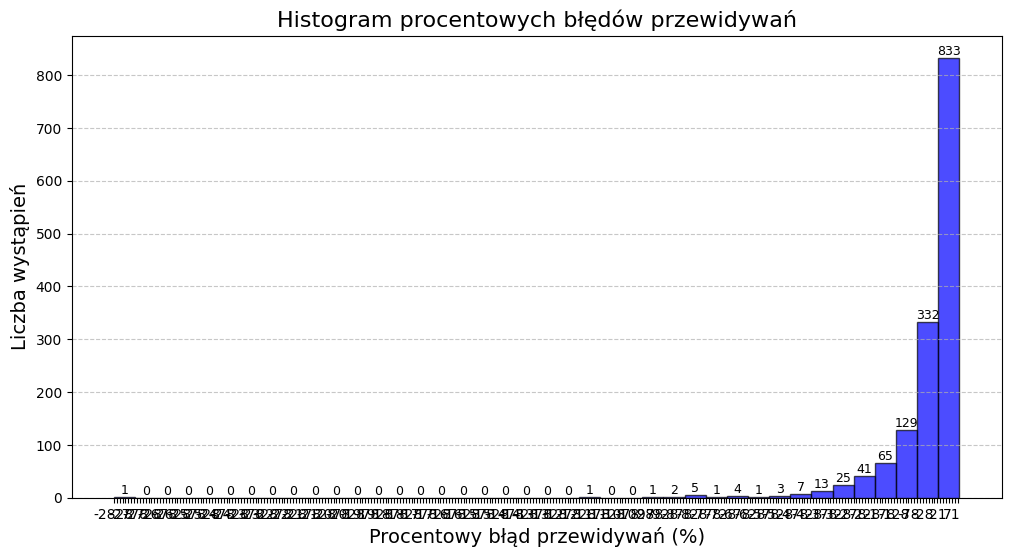

In [9]:
import graphs
import numpy as np
graphs.plot_percentage_error_histogram(np.array(y_pred), np.array(y_true), 40)